# Importing Libraries, Setting Helper Fucnctions and Reading in Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

import math
import os
import statistics
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import anderson

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer


# an initial clean-up function
def clean_up(df,ds='rawdata1'):
    df["YEAR"] = df["YEAR"].astype('str')
    df["MONTH"] = df["MONTH"].astype('str')
    df["DATE"] = df["MONTH"] + '-' + df["YEAR"]
    df["DATE"] =  pd.to_datetime(df["DATE"], format="%m-%Y")
    df['half year'] = np.where(df['DATE'].dt.month.le(6), 'H1', 'H2')
    col = df['half year'] + '-' + df["YEAR"]
    
    if ds == 'rawdata1':
        df["CATEGORY_ID"] = df["CATEGORY_ID"].astype('str')
        df.insert(1,'HALF YEAR',col)
    else:
        df.insert(0,'HALF YEAR',col)
        
    df = df.drop(['YEAR','MONTH','half year'], axis=1)
    df = df.set_index('DATE')
    
    df["STORE"] = df["STORE"].astype('int')
    df["DAYPART"] = df["DAYPART"].astype('str')
    
    return df


# a function to produce pivot tables
def piv_fun(rawdata_1,rawdata_2, piv_type='store'):
    
    daypart_list = ['B','L','D']
    category_list = ['10','15','20','25','30','40','45','50','55','60','99']
    helper_list = ['B','L','D','store']

    if piv_type=='store':
        rawdata_1_filt = rawdata_1
        rawdata_2_filt = rawdata_2
    elif piv_type in daypart_list:
        rawdata_1_filt = rawdata_1[rawdata_1['DAYPART']==piv_type]
        rawdata_2_filt = rawdata_2[rawdata_2['DAYPART']==piv_type]
    else:
        rawdata_1_filt = rawdata_1[rawdata_1['CATEGORY_ID']==piv_type]
  
    # revenue pivot
    rawdata_1_filt_rev = pd.pivot_table(rawdata_1_filt, values='REVENUE_NET', index=['DATE'],
                       columns=['STORE'], aggfunc="sum")
    rawdata_1_filt_rev.columns.name = None
    rawdata_1_filt_rev['Str Smpl Total']= rawdata_1_filt_rev.iloc[:,:].sum(axis=1)
    rawdata_1_filt_rev['Columbus_Region']= rawdata_1_filt_rev.iloc[:,2:4].sum(axis=1)

    # quantity pivot
    rawdata_1_filt_quan = pd.pivot_table(rawdata_1_filt, values='QTY', index=['DATE'],
                       columns=['STORE'], aggfunc="sum")
    rawdata_1_filt_quan.columns.name = None
    rawdata_1_filt_quan['Str Smpl Total']= rawdata_1_filt_quan.iloc[:,:].sum(axis=1)
    rawdata_1_filt_quan['Columbus_Region']= rawdata_1_filt_quan.iloc[:,2:4].sum(axis=1)
    
    # customer count pivot
    if piv_type in helper_list:
        rawdata_2_custcnt = pd.pivot_table(rawdata_2_filt, values='CUSTOMER_COUNT', index=['DATE'],
                           columns=['STORE'], aggfunc="sum")
        rawdata_2_custcnt.columns.name = None
        rawdata_2_custcnt['Str Smpl Total']= rawdata_2_custcnt.iloc[:,:].sum(axis=1)
        rawdata_2_custcnt['Columbus_Region']= rawdata_2_custcnt.iloc[:,2:4].sum(axis=1)

    else:
        rawdata_2_custcnt = None
    
    return rawdata_1_filt_rev,rawdata_1_filt_quan,rawdata_2_custcnt

    
def plot_fun2(df,i,store,ax):
    
    if i==0:
        ax.plot(df[store])
        ax.set_ylim(bottom = 0)
        ax.set_title('Total Revenues')
        ax.tick_params(axis='x', rotation=45)

    if i==1:
        ax.plot(df[store])
        ax.set_ylim(bottom = 0)
        ax.set_title('Total Quantity')
        ax.tick_params(axis='x', rotation=45)
        
    if i+1==3:
        ax.plot(df[store])
        ax.set_title('Average Prices')
        ax.tick_params(axis='x', rotation=45)            
        

# Settings
pd.set_option('display.max_columns', 50)
os.chdir('C:/Users/darre/Documents/Restaurant-Pricing')

In [2]:
def plot_fun1(df,store,ax,**kwargs):
    
    # creating dictionaries to help with subplot titles
    dict_daypart = {0: 'Breakfast',
        1: 'Lunch',
        2: 'Dinner'}
    
    dict_category = {0: 'BREAKFAST',
        1: 'SENIORS MEALS',
        2: 'DINNER',
        3: 'DINNER ALA',
        4: 'LUNCH',
        5: 'SOUP SALAD',
        6: 'KIDS',
        7: 'BEVERAGE',
        8: 'DESSERTS',
        9: 'BRKFST ALA',
       }
    
    # plotting Revenue
    ax.plot(df[0][store],label = 'Net Revenue ($)')
    ax.set_ylim(bottom = 0)

    # plotting Quantity
    ax.plot(df[1][store],label = 'Quantity (units)')

    # plotting Customer Counts
    ax.plot(df[2][store],label = 'Customer Count (units)')
    
    ax.tick_params(axis='x', rotation=45)
    
    # plotting Average Price / Unit
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color='tab:red'
    ax2.plot(df[3][store],color=color,linestyle = '--',label='Average Price / Unit ($)')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom = 0)

    # attending subplot titles
    if kwargs.get('type')=='dp':
        i = kwargs.get('plot_num')
        title = dict_daypart.get(i)
        ax.set_title(title,loc='left')
    if kwargs.get('type')=='cat':
        i = kwargs.get('plot_num')
        title = dict_category.get(i)
        ax.set_title(title)    
    
    # attending legend
    if kwargs.get('type')=='dp':  
        ax.legend(bbox_to_anchor=(1.43,0.9),
          frameon=True)
        ax2.legend(bbox_to_anchor=(1.43,0.4),
              frameon=True)
    elif kwargs.get('type')=='cat':
        pass
    else:
        ax.legend(bbox_to_anchor=(1.52,0.9),
          frameon=True)
        ax2.legend(bbox_to_anchor=(1.52,0.6),
          frameon=True)

In [3]:
rawdata1 = pd.read_csv('RAWDATA1.csv')
rawdata2 = pd.read_csv('RAWDATA2.csv')
rawdata3 = pd.read_csv('RAWDATA3.csv')
rawdata4 = pd.read_csv('RAWDATA4.csv')

# Clean-Up on Data

## RawDate1

In [4]:
rawdata1.head(3)

,YEAR,MONTH,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
0,2018,1,1,B,10,11700,2050
1,2018,1,1,D,10,3700,570
2,2018,1,1,L,10,7700,1270


In [5]:
rawdata1 = clean_up(rawdata1,ds='rawdata1')
rawdata1.head(3)

,HALF YEAR,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY
DATE,,,,,,
2018-01-01,H1-2018,1,B,10,11700,2050
2018-01-01,H1-2018,1,D,10,3700,570
2018-01-01,H1-2018,1,L,10,7700,1270


In [6]:
rawdata1['Avg_Price'] = round(rawdata1['REVENUE_NET'] / rawdata1['QTY'],2)
rawdata1.head(3)

,HALF YEAR,STORE,DAYPART,CATEGORY_ID,REVENUE_NET,QTY,Avg_Price
DATE,,,,,,,
2018-01-01,H1-2018,1,B,10,11700,2050,5.71
2018-01-01,H1-2018,1,D,10,3700,570,6.49
2018-01-01,H1-2018,1,L,10,7700,1270,6.06


## RawDate2

In [7]:
rawdata2.head(3)

,STORE,DAYPART,YEAR,MONTH,CUSTOMER_COUNT
0,1,B,2018,1,3312
1,1,B,2018,2,3366
2,1,B,2018,3,4116


In [8]:
rawdata2 = clean_up(rawdata2,ds='rawdata2')
rawdata2.head(3)

,HALF YEAR,STORE,DAYPART,CUSTOMER_COUNT
DATE,,,,
2018-01-01,H1-2018,1,B,3312
2018-02-01,H1-2018,1,B,3366
2018-03-01,H1-2018,1,B,4116


## RawDate3

In [9]:
rawdata3 = rawdata3.set_index('STORE')
rawdata3.head(3)

,CITY,STATE,NAME,AREA,REGIONAL_DIRECTOR,REGION
STORE,,,,,,
1,RIO GRANDE,OH,RIO GRANDE,1,"GREEN, JOE","GRANDE, OH"
2,CHILLICOTHE,OH,CHILLICOTHE,26,"YELLOW, JAMES","CHILLICOTHE, OH"
3,COLUMBUS,OH,ROUTE 161,7,"YELLOW, JAMES","COLUMBUS, OH"


## RawDate4

In [10]:
rawdata4 = rawdata4.set_index('CATEGORY_ID')
rawdata4.head(4)

,CATEGORY_DESC,COMMENTS
CATEGORY_ID,,
10,BREAKFAST,Breakfast items
15,SENIORS MEALS,Seniors Meals
20,DINNER,Dinner items
25,DINNER ALA,Dinner a-la carte items


## Creating Pivot Tables

In [11]:
# store level pivots
df_store_list = piv_fun(rawdata1,rawdata2, piv_type='store')

# daypart level pivots
df_brkfst_list = piv_fun(rawdata1,rawdata2, piv_type='B')
df_lnch_list = piv_fun(rawdata1,rawdata2, piv_type='L')
df_dnr_list = piv_fun(rawdata1,rawdata2, piv_type='D')

daypart_list = [df_brkfst_list,df_lnch_list,df_dnr_list]

# category level pivots
df_10_list = piv_fun(rawdata1,rawdata2, piv_type='10')
df_15_list = piv_fun(rawdata1,rawdata2, piv_type='15')
df_20_list = piv_fun(rawdata1,rawdata2, piv_type='20')
df_25_list = piv_fun(rawdata1,rawdata2, piv_type='25')
df_30_list = piv_fun(rawdata1,rawdata2, piv_type='30')
df_40_list = piv_fun(rawdata1,rawdata2, piv_type='40')
df_45_list = piv_fun(rawdata1,rawdata2, piv_type='45')
df_50_list = piv_fun(rawdata1,rawdata2, piv_type='50')
df_55_list = piv_fun(rawdata1,rawdata2, piv_type='55')
df_60_list = piv_fun(rawdata1,rawdata2, piv_type='60')
df_99_list = piv_fun(rawdata1,rawdata2, piv_type='99')

# Analysis

## System Wide View

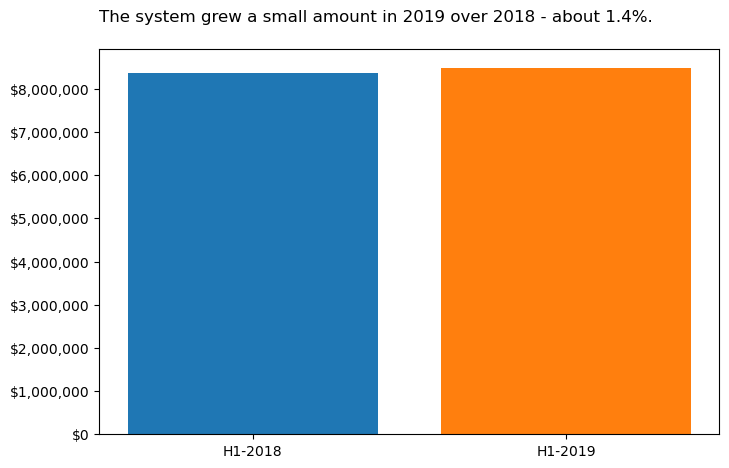

In [280]:
gb1 = rawdata1.groupby(['HALF YEAR'])['REVENUE_NET'].sum()
gb1 = gb1.drop(labels=['H2-2018'])
fig = plt.figure(figsize=(8,5)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.bar(gb1.index,
       gb1,
       color = ['tab:blue','tab:orange'])
ax.set_title('The system grew a small amount in 2019 over 2018 - about 1.4%.', pad=20, loc = 'left')
ax.yaxis.set_major_formatter("${x:,.0f}")
plt.show()

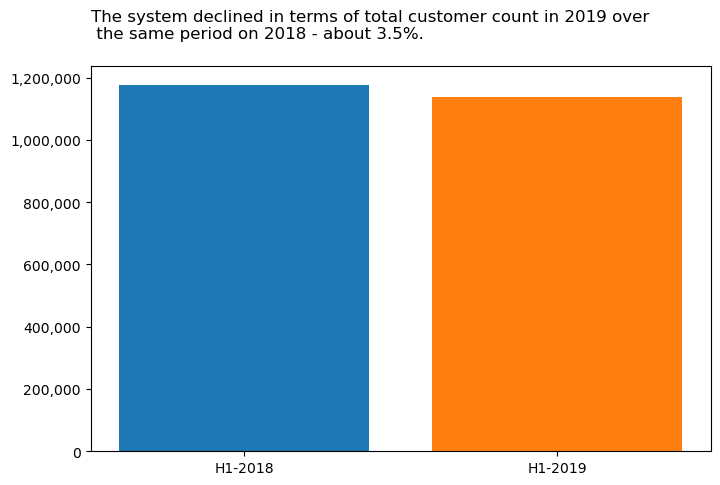

In [279]:
gb2 = rawdata2.groupby(['HALF YEAR'])['CUSTOMER_COUNT'].sum()
gb2 = gb2.drop(labels=['H2-2018'])
fig = plt.figure(figsize=(8,5)) # creating the figure object
ax = fig.add_subplot() # creating the chart (axes?) object
ax.bar(gb2.index,
       gb2,
       color = ['tab:blue','tab:orange'])
ax.set_title('The system declined in terms of total customer count in 2019 over\n \
the same period on 2018 - about 3.5%.', pad=20, loc = 'left')
ax.yaxis.set_major_formatter("{x:,.0f}")

plt.show()

## Store Level View

In [222]:
gb2 = pd.pivot_table(rawdata2, values='CUSTOMER_COUNT', index=['STORE'],
                       columns=['HALF YEAR'], aggfunc="sum")
gb2.columns.name = None

column_to_move = gb2.pop("H1-2019")
gb2.insert(2, "H1-2019", column_to_move)

In [223]:
gb2.head(5)

,H1-2018,H2-2018,H1-2019
STORE,,,
1,106278,116647,104287
2,142544,157363,146512
3,116876,122008,110326
4,62613,66529,63869
5,139471,139406,121467


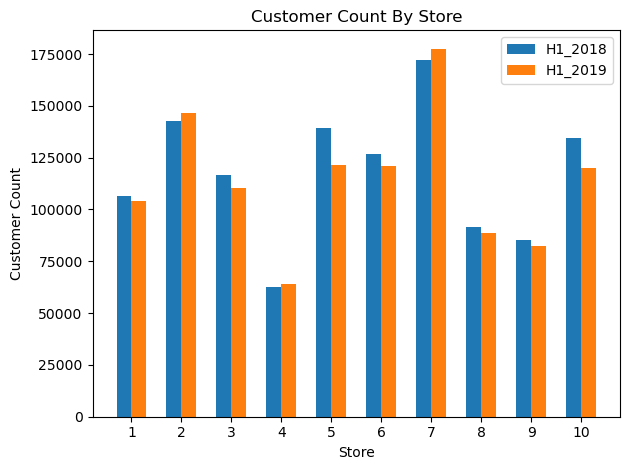

In [224]:
labels = gb2.index # Days

H1_2018 = gb2['H1-2018']
H2_2018 = gb2['H2-2018']
H1_2019 = gb2['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.3 # width of bars

fig, ax = plt.subplots()
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
# p2 = ax.bar(x, H2_2018, width, label = "H2_2018")
p3 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xlabel('Store')
ax.set_title('Customer Count By Store')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(p1, padding=3, fmt="%.2f")
# ax.bar_label(p2, padding=3, fmt="%.2f")
# ax.bar_label(p3, padding=3, fmt="%.2f")

fig.tight_layout()
plt.show()

## Daypart Level View

In [225]:
gb_dp = pd.pivot_table(rawdata2, values='CUSTOMER_COUNT', index=['DAYPART'],
                       columns=['HALF YEAR'], aggfunc="sum")
gb_dp.columns.name = None

column_to_move = gb_dp.pop("H1-2019")
gb_dp.insert(2, "H1-2019", column_to_move)

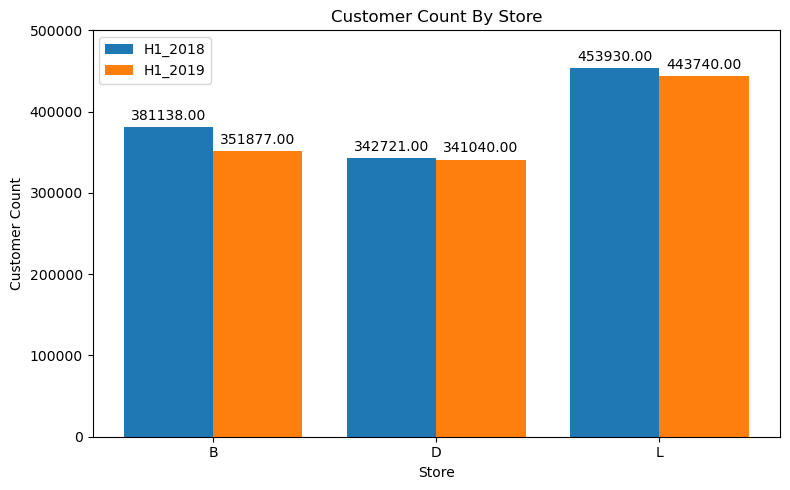

In [285]:
labels = gb_dp.index # Days

H1_2018 = gb_dp['H1-2018']
H2_2018 = gb_dp['H2-2018']
H1_2019 = gb_dp['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.4 # width of bars

fig, ax = plt.subplots(figsize=(8,5))
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
# p2 = ax.bar(x, H2_2018, width, label = "H2_2018")
p3 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xlabel('Store')
ax.set_title('Customer Count By Store')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,500000)
ax.legend()

ax.bar_label(p1, padding=3, fmt="%.2f")
# ax.bar_label(p2, padding=3, fmt="%.2f")
ax.bar_label(p3, padding=3, fmt="%.2f")

fig.tight_layout()
plt.show()

## Breakfast View for Stores 5 and 10

In [293]:
gb_4 = rawdata2[(rawdata2['STORE']==5) | (rawdata2['STORE']==10)]
gb_4 = gb_4[gb_4['DAYPART']=='B']

In [294]:
gb_4 = pd.pivot_table(gb_4, values='CUSTOMER_COUNT', index=['STORE'],
                       columns=['HALF YEAR'], aggfunc="sum")
gb_4.columns.name = None

column_to_move = gb_4.pop("H1-2019")
gb_4.insert(2, "H1-2019", column_to_move)

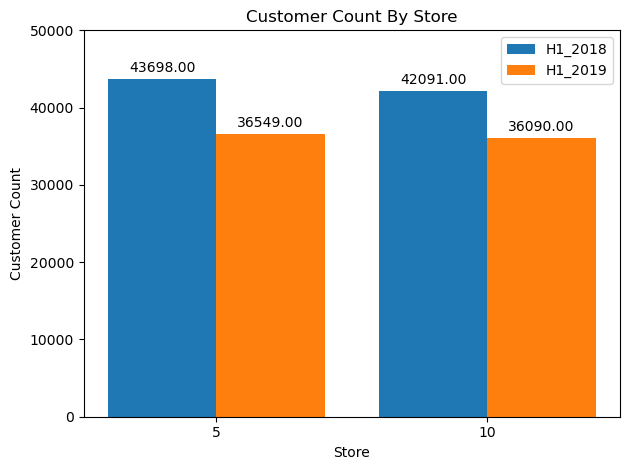

In [297]:
labels = gb_4.index # Days

H1_2018 = gb_4['H1-2018']
H2_2018 = gb_4['H2-2018']
H1_2019 = gb_4['H1-2019']

x = np.arange(len(labels)) # location of x ticks
width = 0.4 # width of bars

fig, ax = plt.subplots()
p1 = ax.bar(x - width/2, H1_2018, width, label = "H1_2018")
# p2 = ax.bar(x, H2_2018, width, label = "H2_2018")
p3 = ax.bar(x + width/2, H1_2019, width, label = "H1_2019")

#labels
ax.set_ylabel('Customer Count')
ax.set_xlabel('Store')
ax.set_title('Customer Count By Store')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,50000)
ax.legend()

ax.bar_label(p1, padding=3, fmt="%.2f")
# ax.bar_label(p2, padding=3, fmt="%.2f")
ax.bar_label(p3, padding=3, fmt="%.2f")

fig.tight_layout()
plt.show()

In [102]:
data

sex,Male,Female
day,,
Thur,2.980333,2.575625
Fri,2.693000,2.781111
Sat,3.083898,2.801786
Sun,3.220345,3.367222


In [98]:
result = pd.DataFrame(gb1)

In [100]:
result

,REVENUE_NET
HALF YEAR,
H1-2018,8372700
H1-2019,8491200


# Plotting Data

In [ ]:
store = '10'
fig = plt.figure(figsize=(7,4)) # creating the figure object
ax = fig.add_subplot()
fig.suptitle('Store 1: Overall View', # title for the figure
              fontsize = 15,
              x = 0.1,
              y = 1.0)

plot_fun1(df_store_list,store,ax)

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(7.5,7.5),sharex=True)
axes = axes.flatten()
fig.suptitle('Store 1: Daypart View', # title for the figure
              fontsize = 15,
              x = 0.1,
              y = 1.0)

for i,axe in enumerate(axes):
    plot_fun1(daypart_list[i],store,axe,plot_num = i,type='dp')

In [ ]:
df_store_list[0]

In [ ]:
df_store_list[1]

In [ ]:
df_store_list[3]

### Breakfast Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_brkfst_list[i],i,store, axe)

### Lunch Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_lnch_list[i],i,store, axe)

### Dinner Level

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun1(df_dnr_list[i],i,store, axe)

### 10 Level

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18, 4))
axes = axes.flatten()

for i,axe in enumerate(axes):
    plot_fun2(df_10_list[i],i,store, axe)